In [1]:
from NLMNN import NLMNN
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from KNN_wrappers import LMNNClassifier, Chi2Classifier, NLMNNClassifier
import numpy as np
import glob
import scipy
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib notebook

In [4]:

classes = {
    'back_pack':1,
    'bike':2,
    'calculator':3,
    'headphones':4,
    'keyboard':5,
    'laptop_computer':6,
    'monitor':7,
    'mouse':8,
    'mug':9,
    'projector':10,
}
X = []
targets=[]
for file in glob.glob('data/webcam/*/*/*.mat'):
    
    target = file.split('/')[3]
    if target in classes:
        targets.append(classes[target])
        X.append(scipy.io.loadmat(file)['histogram'])
X = np.asarray(X, dtype=np.float).squeeze()
y = np.asarray(targets)

n,d = X.shape

X = X/np.sum(X, axis=1, keepdims=True)


In [5]:

scores_c1 = cross_validate(LMNNClassifier(k=3, train=False, pca=20), X, y, cv=5, return_train_score=True, return_estimator=True )
scores_c2 = cross_validate(Chi2Classifier(k=3, r=20), X, y, cv=5, return_train_score=True, return_estimator=True )

steps=10
parameters = {'mu': np.logspace(-2,2, num=steps)}
model = LMNNClassifier(k=3, pca=20)
clf_lmnn = GridSearchCV(model, parameters, cv=5, verbose=3, n_jobs=10)
clf_lmnn.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   31.5s
[Parallel(n_jobs=10)]: Done  48 out of  50 | elapsed:   58.9s remaining:    2.5s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  1.0min finished
/zhome/9e/8/130993/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LMNNClassifier(k=3, mu=0.5, pca=20, train=True),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'mu': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [6]:
model = NLMNNClassifier(k=3, r=20, use_softmax=False)
clf = GridSearchCV(model, parameters, cv=5, verbose=3, n_jobs=10)
clf.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done  48 out of  50 | elapsed:  5.2min remaining:   13.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  5.3min finished
/zhome/9e/8/130993/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=NLMNNClassifier(A_init=None, k=3, l=0.01, lr=1, max_lr_reductions=20, mu=1,
        r=20, use_softmax=False),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'mu': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

loss = 24.999621308198616
number of imposters = 7995


<IPython.core.display.Javascript object>


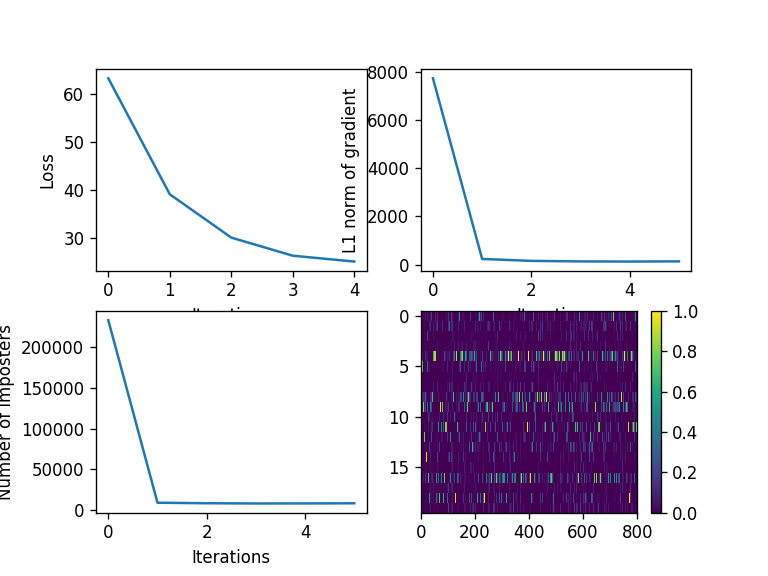

In [20]:
clf.best_estimator_.nlmnn.plot_debug()

<IPython.core.display.Javascript object>


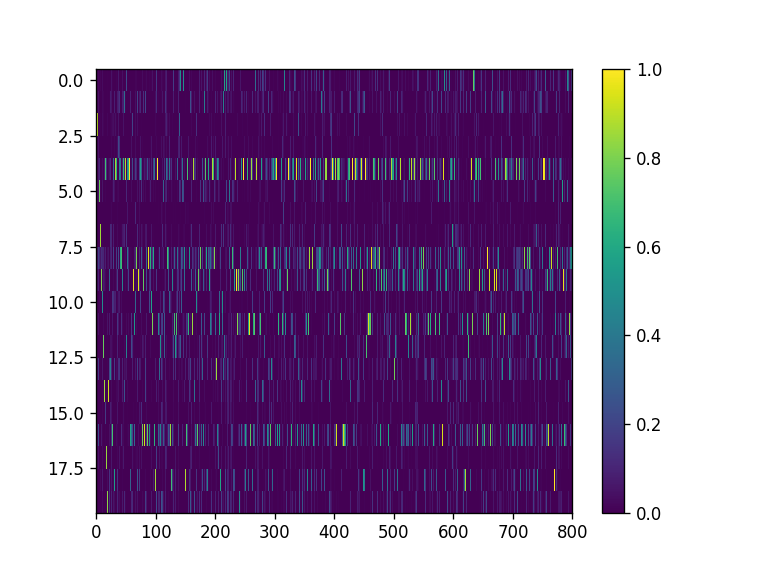

In [27]:
plt.figure()
plt.imshow(clf.best_estimator_.nlmnn.L.T, aspect='auto')
plt.colorbar()

In [8]:
clf.cv_results_['mean_test_score']

array([0.8       , 0.81694915, 0.85762712, 0.8779661 , 0.86779661,
       0.85084746, 0.82711864, 0.82372881, 0.82372881, 0.81694915])

<IPython.core.display.Javascript object>


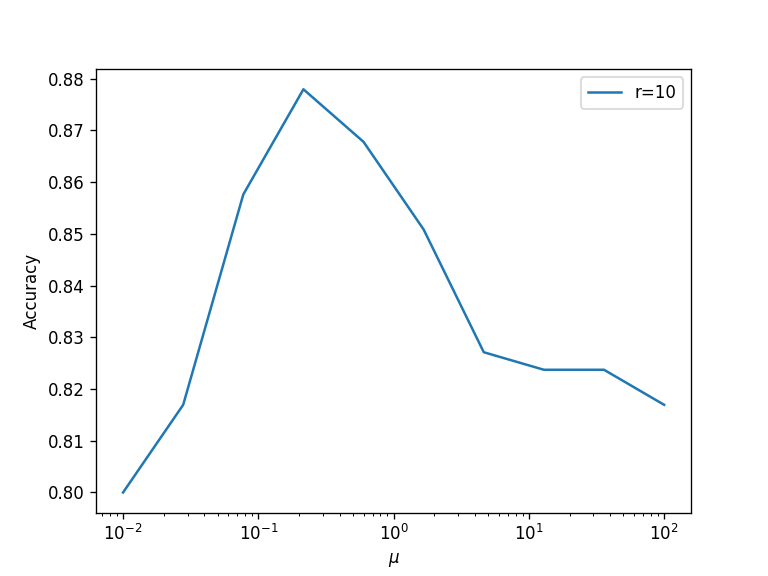

In [21]:

plt.figure()
plt.plot(clf.cv_results_['param_mu'].data,clf.cv_results_['mean_test_score'], label='r=10')

plt.xscale('log')
plt.ylabel('Accuracy')
plt.xlabel('$\mu$')
plt.legend()


In [19]:
print(f"normal           KNN train acc={np.mean(scores_c1['test_score']):.3f} +- {np.std(scores_c1['test_score'])/np.sqrt(5):.3f},  test acc={np.mean(scores_c1['test_score']):.3f} +- {np.std(scores_c1['test_score'])/np.sqrt(5):.3f}")
print(f"trained    LMNN  KNN train acc={clf_lmnn.cv_results_['mean_train_score'][clf_lmnn.best_index_]:.3f} +- {clf_lmnn.cv_results_['std_train_score'][clf_lmnn.best_index_]/np.sqrt(5):.3f},  test acc={clf_lmnn.cv_results_['mean_test_score'][clf_lmnn.best_index_]:.3f} +- {clf_lmnn.cv_results_['std_test_score'][clf_lmnn.best_index_]/np.sqrt(5):.3f}")
print(f"untrained NLMNN  KNN train acc={np.mean(scores_c2['train_score']):.3f} +- {np.std(scores_c2['train_score'])/np.sqrt(5):.3f},  test acc={np.mean(scores_c2['test_score']):.3f} +- {np.std(scores_c2['test_score'])/np.sqrt(5):.3f}")
print(f"trained   NLMNN  KNN train acc={clf.cv_results_['mean_train_score'][clf.best_index_]:.3f} +- {clf.cv_results_['std_train_score'][clf.best_index_]/np.sqrt(5):.3f},  test acc={clf.cv_results_['mean_test_score'][clf.best_index_]:.3f} +- {clf.cv_results_['std_test_score'][clf.best_index_]/np.sqrt(5):.3f}")


normal           KNN train acc=0.790 +- 0.008,  test acc=0.790 +- 0.008
trained    LMNN  KNN train acc=0.936 +- 0.004,  test acc=0.824 +- 0.013
untrained NLMNN  KNN train acc=0.737 +- 0.012,  test acc=0.554 +- 0.020
trained   NLMNN  KNN train acc=0.965 +- 0.003,  test acc=0.878 +- 0.016


In [22]:
parameters={'l':np.logspace(-2,1,num=10)}
model = NLMNNClassifier(k=3, r=20, use_softmax=False, mu=clf.best_params_['mu'])
clf_l = GridSearchCV(model, parameters, cv=5, verbose=3, n_jobs=10)
clf_l.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done  48 out of  50 | elapsed: 53.9min remaining:  2.2min
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed: 60.8min finished
/zhome/9e/8/130993/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=NLMNNClassifier(A_init=None, k=3, l=0.01, lr=1, max_lr_reductions=20,
        mu=0.21544346900318834, r=20, use_softmax=False),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'l': array([ 0.01   ,  0.02154,  0.04642,  0.1    ,  0.21544,  0.46416,
        1.     ,  2.15443,  4.64159, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [23]:
clf_l.cv_results_['mean_test_score']

array([0.8779661 , 0.88135593, 0.86779661, 0.87118644, 0.85084746,
       0.85084746, 0.85423729, 0.85423729, 0.85423729, 0.85423729])

In [24]:
print(f"trained   NLMNN  KNN train acc={clf_l.cv_results_['mean_train_score'][clf_l.best_index_]:.3f} +- {clf_l.cv_results_['std_train_score'][clf_l.best_index_]/np.sqrt(5):.3f},  test acc={clf_l.cv_results_['mean_test_score'][clf_l.best_index_]:.3f} +- {clf_l.cv_results_['std_test_score'][clf_l.best_index_]/np.sqrt(5):.3f}")

trained   NLMNN  KNN train acc=0.976 +- 0.002,  test acc=0.881 +- 0.012


/zhome/9e/8/130993/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/zhome/9e/8/130993/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


<IPython.core.display.Javascript object>


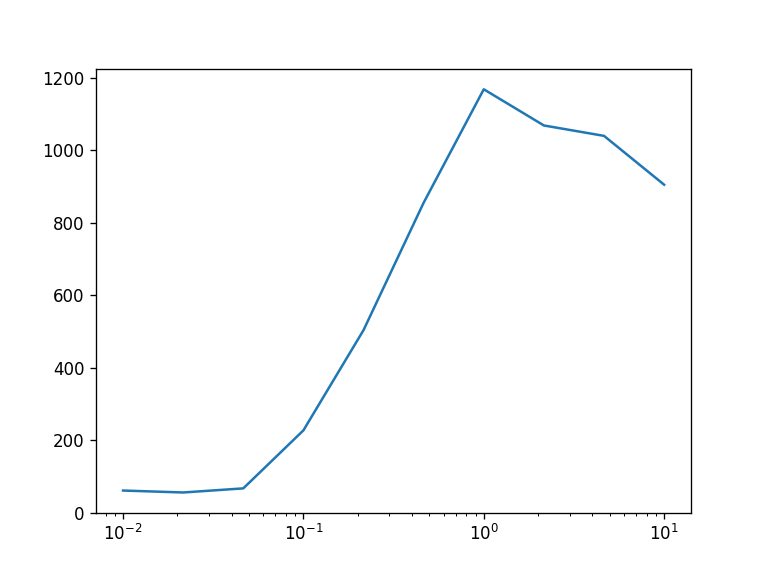

In [25]:
plt.figure()
plt.plot(clf_l.cv_results_['param_l'].data,clf_l.cv_results_['mean_fit_time'])
plt.xscale('log')


<IPython.core.display.Javascript object>


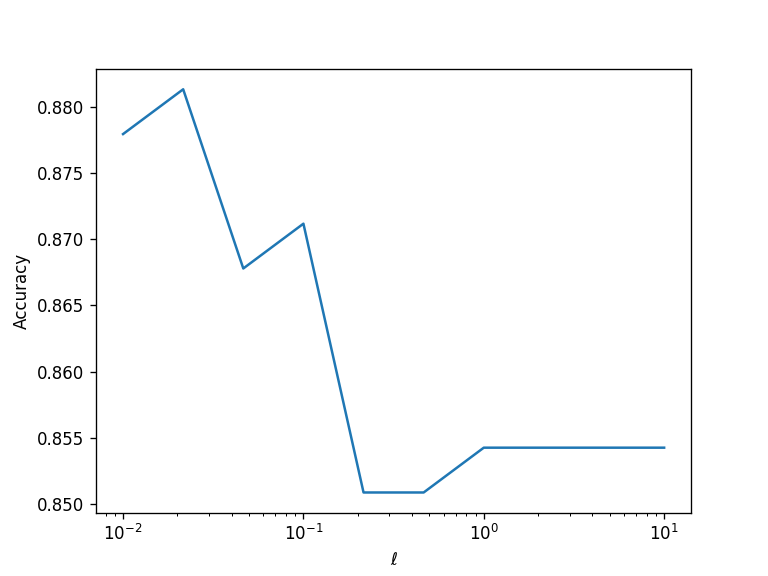

Text(0, 0.5, 'Accuracy')

In [26]:
plt.figure()
plt.plot(clf_l.cv_results_['param_l'].data,clf_l.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('$\ell$')
plt.ylabel('Accuracy')